#### Summary of data cleaning for statistical analysis<br>
<b>Data Description:</b>  There are 2 files for this project, described as identical except for the "class" column in each.  <br> One file classifies the measurements into 1) normal and 2) abnormal, while the second file categorizes more deeply into 1) normal, 2) hernia, and 2) spondylolisthesis.<br>
<b>Validation:</b>  Exploration confirms the files appear to be identical.  The columns are the same, the number of unique values and total values are the same, and the mean & standard deviations of the values are the same, except for abnormal values in 'class', which, as expected, has the "abnormal" values of the one file, categorized into "hernia", and "spondylolishesis" in the other file.<br>
<b>Null Values:</b>  There are no null values, if there were I would have removed these records in this case.<br>
<b>Duplicates:</b>  No reason to address identical values for this case, they are actually expected for medical measurements and should be left.<br>
<b>Outlier's:</b>  Outlier's identified for any degree above 360 and a value for degree of spondylolisthesis >400 was removed.  To understand better why please see the image below of how degree's are measured.  Without the ability to consult the medical staff on this it is not wise to include a value that is 4 times the expected maximum value.<br>
<br>
<br>
I followed the following steps below:<br>
1) Validate the data is as expected<br>
2) Examine for: null values, duplicates, outliers and address as necessary<br>
3) Visualize the distribution of the data
4) Test for statistical significance
5) Report results


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from numpy.random import seed
from scipy.stats import gamma

import arviz as az

<b> Load files and visually compare - they should be identical</b>

In [98]:
classify = pd.read_csv('weka2c.csv')
classify.info()
classify.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt numeric         310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [99]:
# Compare values to previous files "weka2c", they should be identical.....
category = pd.read_csv('weka3c.csv')
category.info()
category.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt                 310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


<b> Compare counts to validate for identical data as expected, except for the "class" column which should be 2 for the basic classification of abnormal/normal and 3 for the categorized data of hernia/spondylolisthesis/normal.<br> <br>Also interesting note we have some duplicates (count < 310) but for medical measurements these are expected and will not need to be addressed. <br> </b>

In [100]:
# Review first file for uniqueness
print(classify.nunique())

pelvic_incidence            310
pelvic_tilt numeric         310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         2
dtype: int64


In [101]:
# Revies and compare second file to first
print(category.nunique())

pelvic_incidence            310
pelvic_tilt                 310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         3
dtype: int64


In [102]:
# Review the "class" column value counts, note they add up to 310 rows as expected
classify["class"].value_counts()

Abnormal    210
Normal      100
Name: class, dtype: int64

In [103]:
# Review the "class" column in the second file - note the normal count matches
 #the classify data and the total count  is 310 as we expect
category["class"].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

<b>  Outliers:<br><sp><sp><sp><sp>We know angles cannot be greater than 360 degrees with a special note: degree of spondylolisthesis is not measuring actual degrees but is a percentage measurement.

In [104]:
df2vals = classify["degree_spondylolisthesis"]
df3vals = category["degree_spondylolisthesis"]
print(classify.head(310))

     pelvic_incidence  pelvic_tilt numeric  lumbar_lordosis_angle  \
0           63.027818            22.552586              39.609117   
1           39.056951            10.060991              25.015378   
2           68.832021            22.218482              50.092194   
3           69.297008            24.652878              44.311238   
4           49.712859             9.652075              28.317406   
..                ...                  ...                    ...   
305         47.903565            13.616688              36.000000   
306         53.936748            20.721496              29.220534   
307         61.446597            22.694968              46.170347   
308         45.252792             8.693157              41.583126   
309         33.841641             5.073991              36.641233   

     sacral_slope  pelvic_radius  degree_spondylolisthesis     class  
0       40.475232      98.672917                 -0.254400  Abnormal  
1       28.995960     114.405

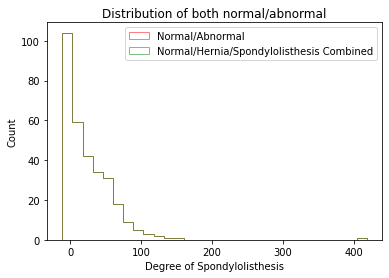

In [105]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(df2vals, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(df3vals, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal/abnormal")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [106]:
#  Merge the files and rename the columns for ease-of-use
#  Note from now on the only separation of the 2 files is the 2 columns "category" and "class"
df = pd.merge(category, classify, on='degree_spondylolisthesis', how='right')
df2 = df[['pelvic_incidence_x', 'pelvic_tilt', 'lumbar_lordosis_angle_x', 'sacral_slope_x', 'pelvic_radius_x', 'degree_spondylolisthesis','class_x','class_y']]
df = df2.rename(columns = {'pelvic_incidence_x':'incidence', 'pelvic_tilt': 'tilt', 'lumbar_lordosis_angle_x': 'angle', 'sacral_slope_x': 'slope', 'pelvic_radius_x': 'radius', 'degree_spondylolisthesis' : 'degree', 'class_x' : 'category', 'class_y':'class'})
print(df.count(axis='rows'))

incidence    310
tilt         310
angle        310
slope        310
radius       310
degree       310
category     310
class        310
dtype: int64


In [107]:
# slice and plot "normal" data from both the category and class
class_norm = df.loc[df['class'] == 'Normal']['degree']
cat_norm = df.loc[df['category'] == 'Normal']['degree']

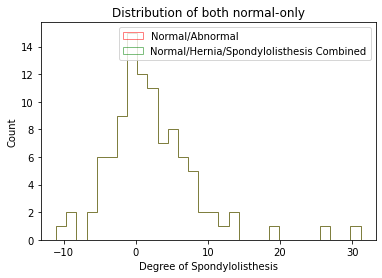

In [108]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(class_norm, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(cat_norm, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal-only")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [109]:
# slice and plot "abnormal" data from both the category and class
class_abn = df.loc[df['class'] == 'Abnormal']['degree']
cat_abn = df.loc[df['category'] != 'Normal']['degree']

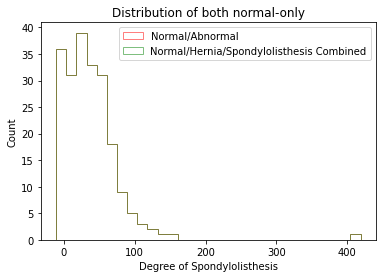

In [110]:
# The plot shows all lines in brown, indicating both data points overlap
# Note that the overall data is exponential in shape.
_ = plt.hist(class_abn, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Normal/Abnormal')
_ = plt.hist(cat_abn, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Normal/Hernia/Spondylolisthesis Combined')
_ = plt.title("Distribution of both normal-only")
_ = plt.xlabel("Degree of Spondylolisthesis")
_ = plt.ylabel("Count")
_ = plt.legend()

In [111]:
# remove the ouliers, values > 360
df = df.loc[df['degree'] <= 360].copy(deep=True)

#### Analysis <br>


In [112]:
# slice"abnormal" data
classified = df.loc[df['class'] == 'Abnormal']['degree']
hernia = df.loc[df['category'] == 'Hernia']['degree']
spondylolisthesis = df.loc[df['category'] == 'Spondylolisthesis']['degree']

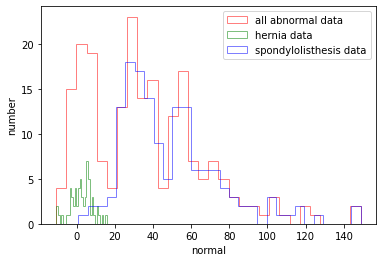

In [113]:
# The plot of abnormal results
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'all abnormal data')
_ = plt.hist(hernia, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'hernia data')
_ = plt.hist(spondylolisthesis, histtype = 'step', bins=30, alpha=0.5, color ='blue', label = 'spondylolisthesis data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

<b> Below we see that any degree of spondylolithesis greater than 30 is automatically an abnormal result.<br>  Also we see the normal results are distributed normally around the 0 value, while abnormal results are shaped more exponentially leaning right.</b>

(array([39., 30., 50., 32., 29., 15.,  5.,  4.,  3.,  2.]),
 array([-10.67587083,   5.26708734,  21.21004552,  37.15300369,
         53.09596186,  69.03892004,  84.98187821, 100.92483638,
        116.86779455, 132.81075273, 148.7537109 ]),
 [<matplotlib.patches.Polygon at 0x2a3178b4348>])

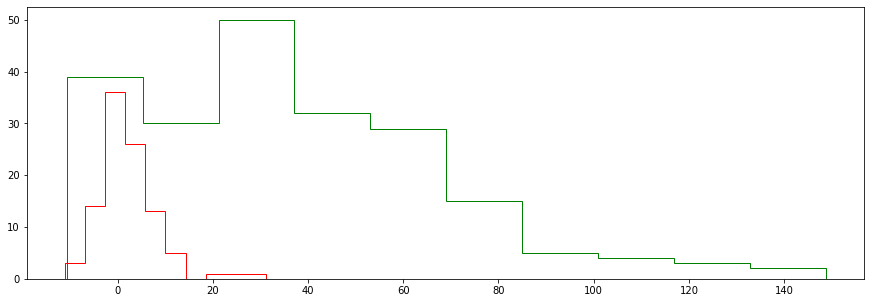

In [114]:
normal = df[df['class'] == 'Normal']['degree']
abnormal = df[df['class'] == 'Abnormal']['degree']

plt.figure(figsize=[15,5])
plt.hist(normal, histtype='step', color = 'red')
plt.hist(abnormal, histtype='step', color = 'green')

<b> The correlations in the below pairplot show many noteworthy items.  <br> First, looking at the degree column we can see again that values above 30 are clearly abnormal and normal is strictly a normal shape around 0 <br>
Secondly, all abnormal values tend to be greater than normal in values for features such as angle, tilt, and incidence, EXCEPT for radius which tends to me the opposite, lower or equal in value to normals.  

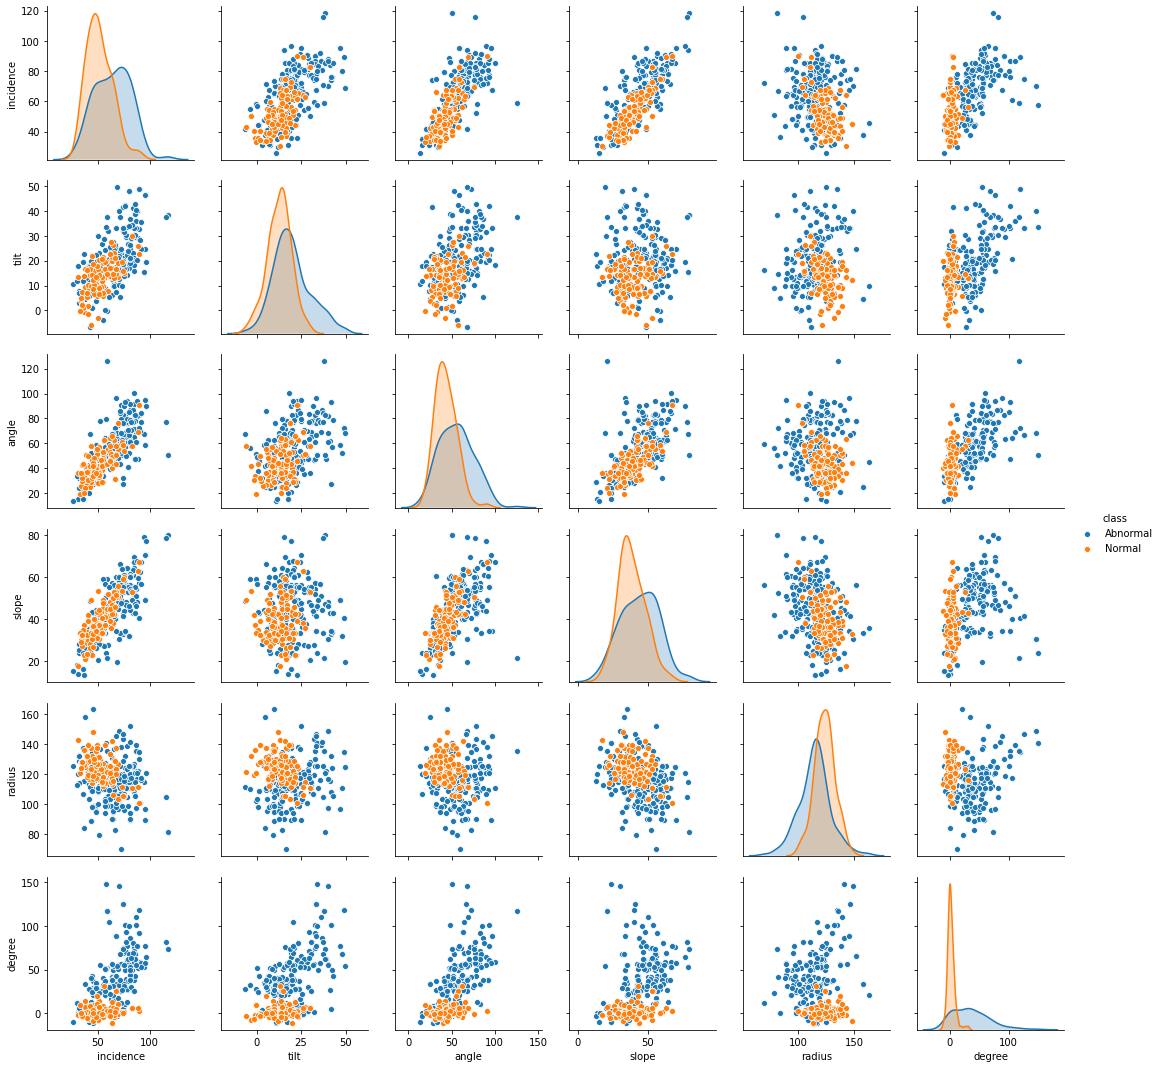

In [115]:
sns.pairplot(df, hue="class")
plt.show()

In [116]:
print(df.corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.659553  0.739510  0.804772 -0.244163  0.642157
tilt        0.659553  1.000000  0.432809  0.084618  0.030461  0.534300
angle       0.739510  0.432809  1.000000  0.638521 -0.080903  0.672138
slope       0.804772  0.084618  0.638521  1.000000 -0.347722  0.429320
radius     -0.244163  0.030461 -0.080903 -0.347722  1.000000 -0.000023
degree      0.642157  0.534300  0.672138  0.429320 -0.000023  1.000000


In [117]:
df['class']=df['class'].map({'Normal':0,'Abnormal':1})

In [139]:
abn = df[(df['class'] != 0)]
nor = df[(df['class'] == 0)]

<b> Interesting comparison between the Abnormal correlation set and the full dataset correlation with a marked increase in pelvic radius being correlated. <BR>  What I find interesting about this is the potential to weight the radius as more important that we might have initially thought.  If we do a weighted analysis these comparisons would be important.

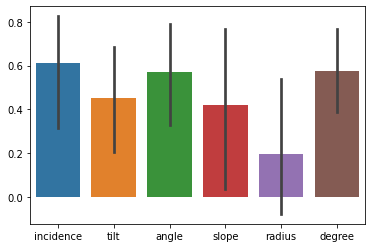

In [133]:
# Abnormal dataset correlation 
correlate = abn.corr()
correlate = correlate.drop(columns = ["class"])
correlate.sort_values(by = "degree",inplace=True)
ax = sns.barplot(data=correlate)

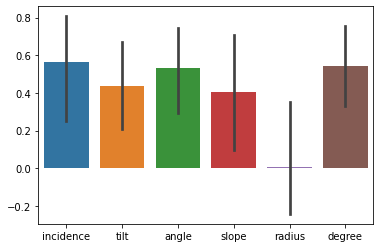

In [134]:
# Full dataset correlation, notice the 
corr2 = df.corr()
corr2 = corr2.drop(columns = ["class"])
corr2.sort_values(by="degree", inplace=True)
ax = sns.barplot(data=corr2)

<b> Statistical inference analysis.  <br> To begin let's determine the shape of the distributions of the abnormal results.

In [165]:
abn = df[(df['class'] != 0)]
nor = df[(df['class'] == 0)]
abn = abn["degree"]
nor = nor["degree"]
n_abn = len(abn)
n_nor = len(nor)

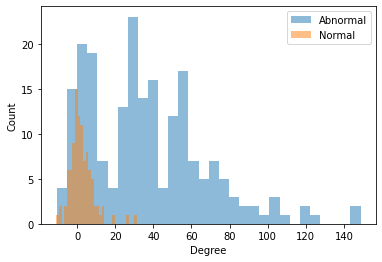

In [167]:
_ = plt.hist(abn, bins=30, alpha=0.5, label='Abnormal')
_ = plt.hist(nor, bins=30, alpha=0.5, label='Normal')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Count')
_ = plt.legend()

In [168]:
alpha_est = np.mean(abn)**2 / np.var(abn)
beta_est = np.var(nor) / np.mean(nor)
alpha_est, beta_est

(1.347800055346333, 18.012896329685613)

In [169]:
seed(47)
abn_rvs = gamma(alpha_est, scale=beta_est).rvs(n_abn)

<b> The graph below shows the orinial abnormal data compared to the random variates using an eponential scale

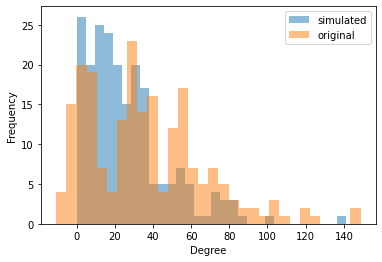

In [181]:
_ = plt.hist(abn_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(abn, bins=30, alpha=0.5, label='original')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Frequency')
_ = plt.legend()

<b> Running a ttest comparing all the features correlation with the degree of spondylolisthesis, only the radius 

In [205]:
aabn = df[(df['degree'] != 0)]
gabn = aabn["angle"].copy()
iabn = aabn["incidence"].copy()
sabn = aabn["slope"].copy()
dabn = aabn["degree"].copy()
rabn = aabn["radius"].copy()

In [206]:
     #importing ttest_ind gives similar results
from scipy.stats import ttest_ind
print( "Angle ttest results: ")
ttest_ind(abn,gabn)

Angle ttest results: 


Ttest_indResult(statistic=-7.3200393192681625, pvalue=9.56877757260715e-13)

In [207]:
print( "Incidence ttest results: ")
ttest_ind(abn,iabn)

Incidence ttest results: 


Ttest_indResult(statistic=-11.503413547267273, pvalue=2.0311651666544504e-27)

In [209]:
print( "Slope ttest results: ")
ttest_ind(abn,sabn)

Slope ttest results: 


Ttest_indResult(statistic=-3.421246012204748, pvalue=0.000672789356283565)

In [210]:
print( "Degree ttest results: ")
ttest_ind(abn,dabn)

Degree ttest results: 


Ttest_indResult(statistic=3.992484266668348, pvalue=7.487381678511185e-05)

In [211]:
print( "Radius ttest results: ")
ttest_ind(abn,rabn)

Radius ttest results: 


Ttest_indResult(statistic=-41.17168502461475, pvalue=3.6068534902310904e-165)